In [1]:
import gym
import torch
import lbforaging
import decision_transformer.models.decision_transformer
import numpy as np
from itertools import product

import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
env_name = "lbforaging_separate-medium-v2"

dataset_path = f'data/{env_name}.pkl'
with open(dataset_path, 'rb') as f:
    trajectories = pickle.load(f)
    
states, traj_lens, returns = [], [], []
for path in trajectories:
    states.append(path['states'])

# used for input normalization
states = np.concatenate(states, axis=0)
state_mean_global, state_std_global = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

In [27]:
path_to_model = "/work3/s174437/Blankuca/decision-transformer/dataset/saved_models/model_cooperative.pt"

In [34]:
behavior = "cooperative"
env = gym.make("Foraging-8x8-2p-3f-v2")
state_dim = env.observation_space[0].shape[0] * 2
act_dim = 1
device='cpu'
model = torch.load(path_to_model, map_location=torch.device('cpu'))
max_ep_len=10
scale=1
target_return=torch.Tensor([0.5,0.5], device=device)
mode='normal'
state_mean=state_mean_global
state_std=state_std_global

In [35]:
model.eval()
model.to(device=device)

num_agents = env.n_agents

state_mean = torch.from_numpy(state_mean).to(device=device)
state_std = torch.from_numpy(state_std).to(device=device)

states = env.reset()
env_global = env
state = np.concatenate(states)
if mode == 'noise':
    state = state + np.random.normal(0, 0.1, size=state.shape)

# we keep all the histories on the device
# note that the latest action and reward will be "padding"
states = torch.from_numpy(state).reshape(1, state_dim).to(device=device, dtype=torch.float32)
actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
rewards = torch.zeros(num_agents, 0, device=device, dtype=torch.float32)

ep_return = target_return
target_return = torch.tensor(ep_return, device=device, dtype=torch.float32).reshape(num_agents,1, 1)
timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)

sim_states = []

avail_actions = list(range(len(env.action_set) + 1))
combinations = list(product(avail_actions, repeat=num_agents))
enc_action_to_actions = {i:comb for i,comb in enumerate(combinations)}
actions_to_enc_actions = {comb:i for i,comb in enumerate(combinations)}

episode_return, episode_length = torch.zeros(num_agents, device=device, dtype=torch.float32), 0

record_actions = []
for t in range(max_ep_len):

    # add padding
    actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
    rewards = torch.cat([rewards, torch.zeros(num_agents,1, device=device)], dim=1)


    action = model.get_action(
        (states.to(dtype=torch.float32) - state_mean) / state_std,
        actions.to(dtype=torch.float32),
        rewards.to(dtype=torch.float32),
        target_return.to(dtype=torch.float32),
        timesteps.to(dtype=torch.long),
    )
    action = action.argmax(dim=1).tolist()
    record_actions.append(action)
    actions[-1] = actions_to_enc_actions[tuple(action)]

    state, reward, done, _ = env.step(action)
    state = np.concatenate(state)

    reward = torch.FloatTensor(reward).to(device=device)
    episode_return = episode_return.add(reward)
    episode_length += 1
    
    done = all(done)

    cur_state = torch.from_numpy(state).to(device=device).reshape(1, state_dim)
    states = torch.cat([states, cur_state], dim=0)
    rewards[:,-1] = reward

    if mode != 'delayed':
        pred_return = target_return[:,0,-1].sub(reward/scale)
    else:
        pred_return = target_return[:,0,-1]
    target_return = torch.cat(
        [target_return, pred_return.reshape(-1, 1, 1)], dim=1)
    timesteps = torch.cat(
        [timesteps,
            torch.ones((1, 1), device=device, dtype=torch.long) * (t+1)], dim=1)

    if done:
        break

/tmp/ipykernel_453/2872041258.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_return = torch.tensor(ep_return, device=device, dtype=torch.float32).reshape(num_agents,1, 1)


In [36]:
len(actions)

10

In [37]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % ("env",step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

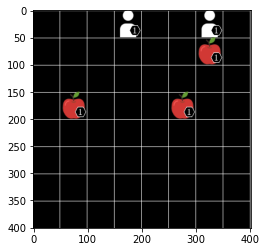

In [38]:
import gym
from gym import wrappers

env = env_global
for action in record_actions:
    plt.imshow(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    env.step(action)

In [39]:
done

False